In [1]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
import os

In [2]:
f_zip = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

## loading data 
Ce dataset décrit un problème de classification binaire : un client acceptera-t-il une offre marketing, oui ou non ? Il contient un peu plus de 41 000 échantillons clients étiquetés.

D'après de la description officielle du dataset - https://archive.ics.uci.edu/ml/datasets/Bank+Marketing 
ci-dessous la liste des variables que ce dataset contient: 
Input variables:

    1. age (numeric)
    2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
    4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
    5. default: has credit in default? (categorical: 'no','yes','unknown')
    6. housing: has housing loan? (categorical: 'no','yes','unknown')
    7. loan: has personal loan? (categorical: 'no','yes','unknown')
    8. contact: contact communication type (categorical: 'cellular','telephone')
    9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
    11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
    12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    14. previous: number of contacts performed before this campaign and for this client (numeric)
    15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Output variable (desired target):

    21. y. has the client subscribed a term deposit? (binary: 'yes','no')
    


In [6]:
df=pd.read_csv('bank-additional/bank-additional-full.csv', sep=';',header=0)

In [7]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
# supprimer les lignes avec des valeurs manquantes 
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

nous comptons les échantillons négatifs et positifs et affichons le rapport de classe. Cela nous indiquera à quel point l'ensemble de données est déséquilibré :

In [10]:
one_class = df[df['y']=='yes']
one_class_count = one_class.shape[0]
zero_class = df[df['y']=='no']
zero_class_count = zero_class.shape[0]
zero_to_one_ratio = zero_class_count/one_class_count
print("Ratio: %.2f" % zero_to_one_ratio)

Ratio: 7.88


<AxesSubplot:title={'center':'Distribution of Subscriptions'}, xlabel='y', ylabel='count'>

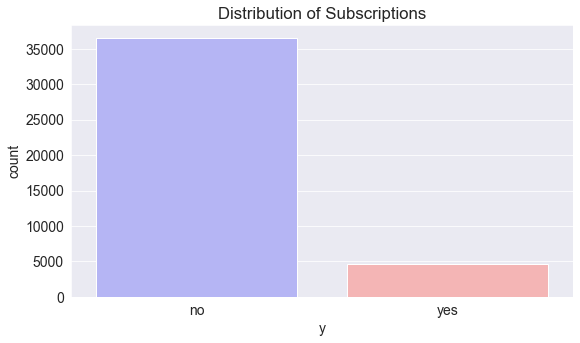

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
# Configuring styles
sns.set_style("darkgrid")
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['figure.facecolor'] = '#00000000'

plt.title("Distribution of Subscriptions")

sns.countplot(x="y", data=df, palette="bwr")

En regardant le dataset, nous pouvons voir une colonne nommée pdays, nous indiquant depuis combien de temps un client a été contacté. Certaines lignes ont une valeur de 999, et cela semble assez suspect : en effet, il s'agit d'une valeur fictive signifiant qu'un client n'a jamais été contacté. Pour aider le modèle à comprendre cette hypothèse, ajoutons une nouvelle colonne l'énonçant explicitement :

In [12]:
import numpy as np
df['no_previous_contact'] = np.where(df['pdays'] == 999,1, 0)

Dans la colonne job, on peut voir trois catégories (student, retired, and unemployed) qu'il faudrait probablement regrouper pour  indiquer que ces clients n'ont pas d'emploi à temps plein

In [13]:
df['not_working'] = np.where(np.in1d(df['job'],['student', 'retired', 'unemployed']), 1, 0)

In [14]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,no_previous_contact,not_working
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1,0


In [25]:
from sklearn.preprocessing import StandardScaler

# Copying original dataframe
df_bank_ready = df.copy()

scaler = StandardScaler()
num_cols = ['age', 'duration', 'campaign', 'pdays', 'previous']
df_bank_ready[num_cols] = scaler.fit_transform(df_bank_ready[num_cols])

df_bank_ready.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,no_previous_contact,not_working
0,1.533143,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,-0.349551,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1,0
1,1.629107,services,married,high.school,unknown,no,no,telephone,may,mon,...,-0.349551,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1,0
2,-0.290177,services,married,high.school,no,yes,no,telephone,may,mon,...,-0.349551,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1,0
3,-0.002284,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,-0.349551,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1,0
4,1.533143,services,married,high.school,no,no,yes,telephone,may,mon,...,-0.349551,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1,0


In [26]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Encode Categorical Data
df_encoded = pd.DataFrame(encoder.fit_transform(df_bank_ready[cat_cols]))
df_encoded.columns = encoder.get_feature_names(cat_cols)

# Replace Categotical Data with Encoded Data
df_bank_ready = df_bank_ready.drop(cat_cols ,axis=1)
df_bank_ready = pd.concat([df_encoded, df_bank_ready], axis=1)

df_bank_ready['y'] = df_bank_ready['y'].apply(lambda x: 1 if x == 'yes' else 0)
print('Shape of dataframe:', df_bank_ready.shape)
df_bank_ready.head()

Shape of dataframe: (41188, 62)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,no_previous_contact,not_working
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.195443,-0.349551,1.1,93.994,-36.4,4.857,5191.0,0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.195443,-0.349551,1.1,93.994,-36.4,4.857,5191.0,0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.195443,-0.349551,1.1,93.994,-36.4,4.857,5191.0,0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.195443,-0.349551,1.1,93.994,-36.4,4.857,5191.0,0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.195443,-0.349551,1.1,93.994,-36.4,4.857,5191.0,0,1.0,0.0


In [28]:
# Select Features
feature = df_bank_ready.drop('y', axis=1)

# Select Target
target = df_bank_ready['y']

# Set Training and Testing Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)

# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (32950, 61)
Shape of testing feature: (8238, 61)
Shape of training label: (32950,)
Shape of training label: (8238,)
